In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

In [3]:
# Recorded FEMA Disasters (through 2018)
fema_disaster = pd.read_csv('https://www.dropbox.com/s/csf8o84x2olw7n2/clean_fema_data?dl=1')

# Quaterly Work Indicators (through Q1 2018)
qwi = pd.read_csv('https://www.dropbox.com/s/fuvc3s6d40ydc45/master_qwi_2003_2018.csv?dl=1')

In [4]:
# Drop unnamed columns
qwi.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
fema_disaster.drop(['Unnamed: 0'], inplace = True, axis = 1)

# Set datetime index
qwi.index = pd.DatetimeIndex(qwi['time'].values)

In [5]:
disaster_time = [2003, 2004, 2005, 2006, 2007, 2008, 2009,
                2010, 2011, 2012, 2013, 2014, 2015, 2016,
                2017, 2018]

disaster_time = '|'.join(str(q) for q in disaster_time)

In [6]:
# Isolate disasters between 2003 - 2018
fema_disaster_2003_2018 = fema_disaster[fema_disaster['time'].str.contains(disaster_time)]

In [7]:
# Determine top disaster locations
disaster_count = fema_disaster_2003_2018['State '].value_counts().sort_values(ascending = False)

# Select top 10 states
disaster_count_10 = disaster_count[0:10]

# Convert to list with pipe seperator
disaster_count_10 = disaster_count_10.index.tolist()

disaster_count_10 = '|'.join(s for s in disaster_count_10)

In [8]:
# Isolate top 10 disaster states in QWI
qwi_top_10 = qwi[qwi['state_abv'].str.contains(disaster_count_10)]

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


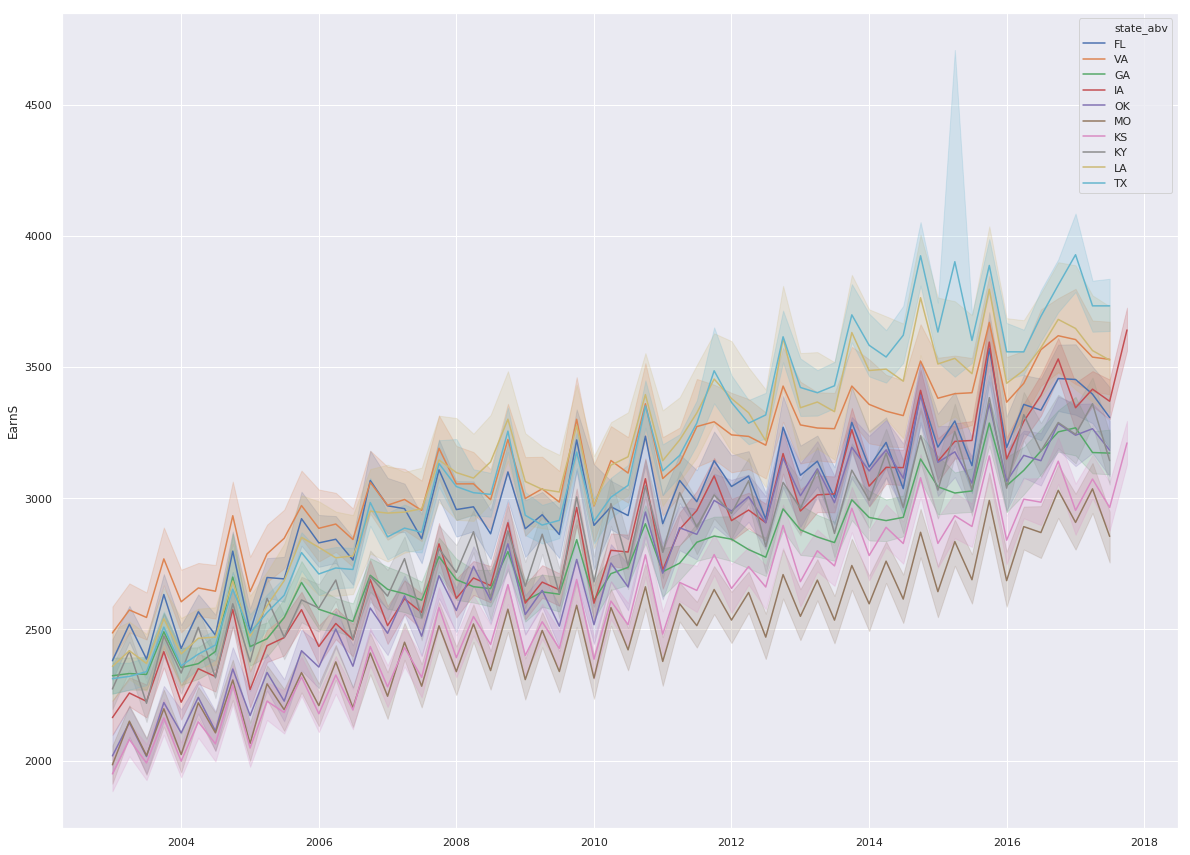

In [9]:
# Plot Stable Earnings
plt.figure(figsize=(20,15))
sns.lineplot(x = qwi_top_10.index, y = 'EarnS',
             hue = 'state_abv', data = qwi_top_10)

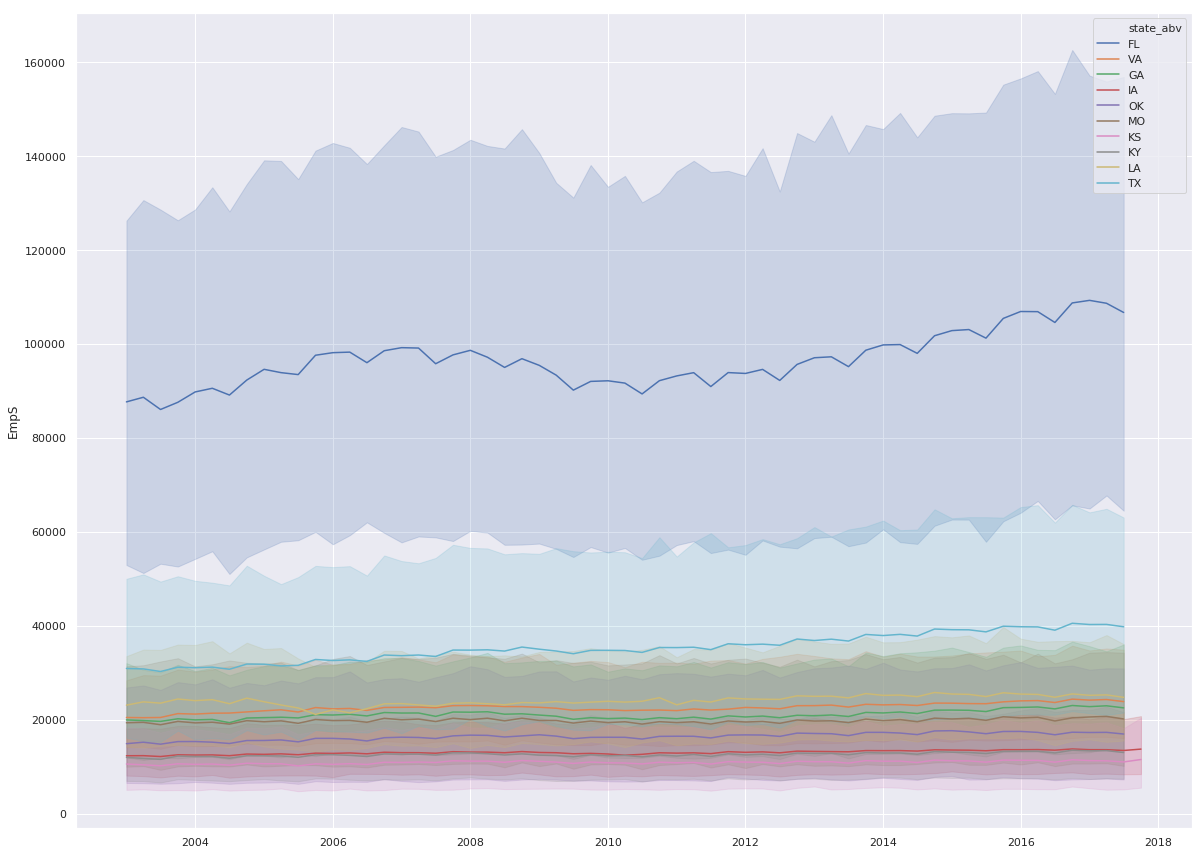

In [10]:
# Plot Stable Employment
plt.figure(figsize=(20,15))
sns.lineplot(x = qwi_top_10.index, y = 'EmpS',
             hue = 'state_abv', data = qwi_top_10)

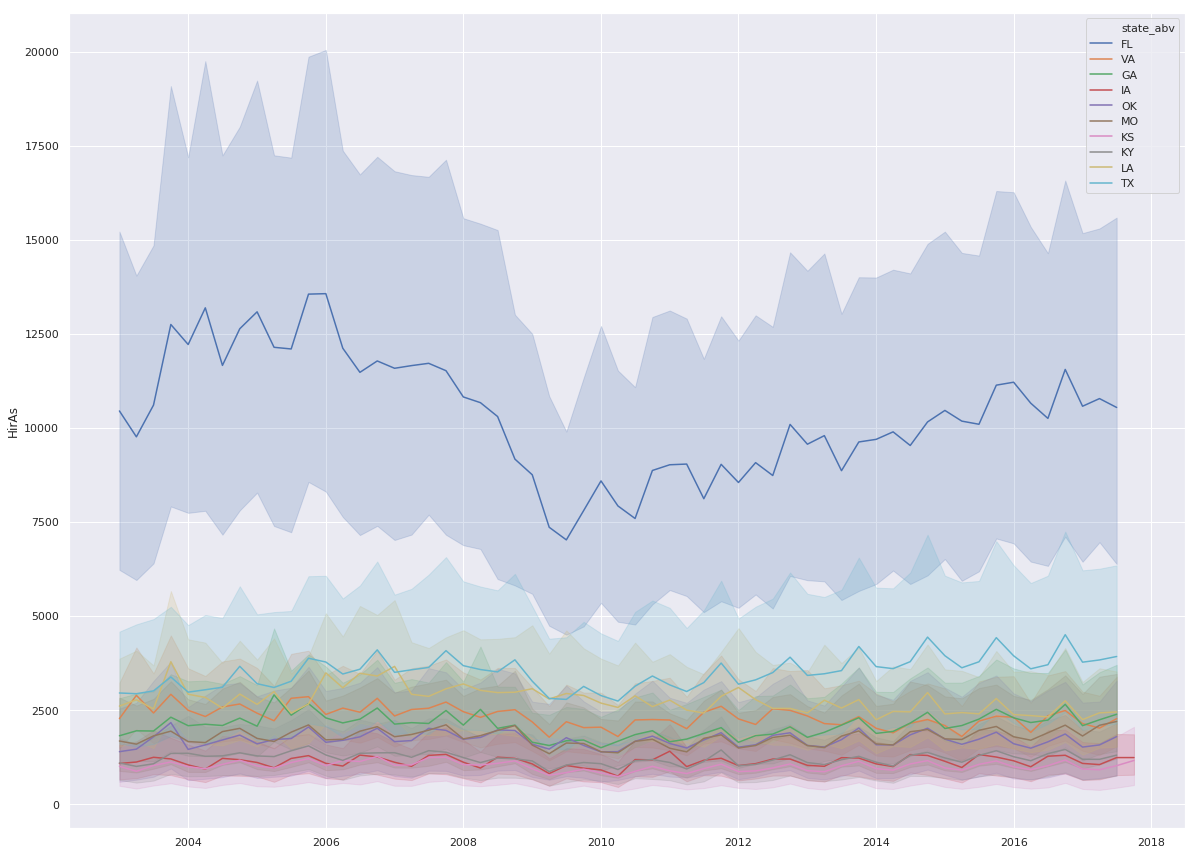

In [11]:
# Plot Stable Hiring
plt.figure(figsize=(20,15))
sns.lineplot(x = qwi_top_10.index, y = 'HirAs',
             hue = 'state_abv', data = qwi_top_10)

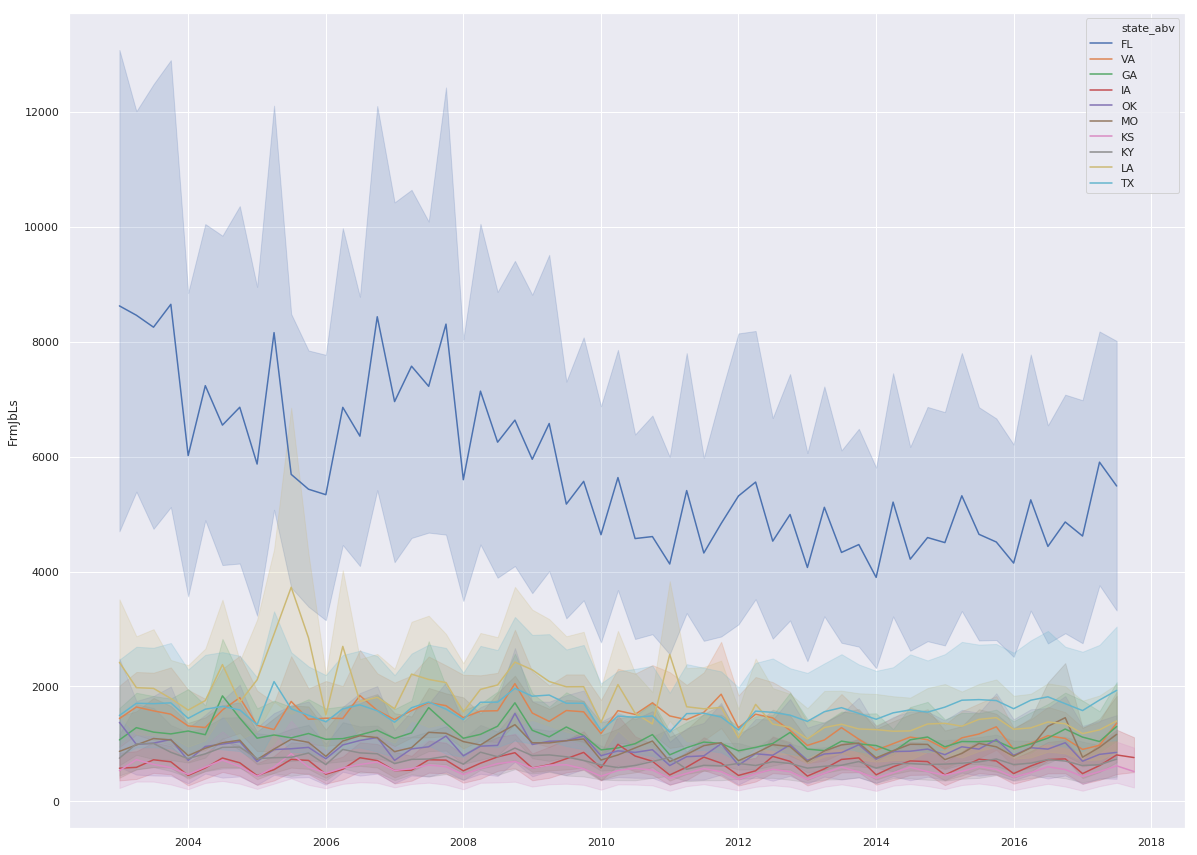

In [12]:
# Plot Stable JobLoss
plt.figure(figsize=(20,15))
sns.lineplot(x = qwi_top_10.index, y = 'FrmJbLs',
             hue = 'state_abv', data = qwi_top_10)

In [13]:
# Concat State & County
fema_disaster_2003_2018['county_state'] = fema_disaster_2003_2018['State '].astype(str) + '-' + fema_disaster_2003_2018['Declared County/Area']

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# Count of disasters
fema_disaster_2003_2018.groupby('Incident Type')['Disaster Number'].count().sort_values(ascending = False).head(10)

Incident Type
Severe Storm(s)     10541
Hurricane            8252
Flood                2094
Fire                 1516
Severe Ice Storm     1312
Snow                 1177
Coastal Storm         305
Other                 200
Tornado               132
Typhoon                32
Name: Disaster Number, dtype: int64

In [15]:
# Sort states / counties with largest numbers of disasters
county_disaster_count = fema_disaster_2003_2018['county_state'].value_counts()

county_disaster_count_25 = county_disaster_count[:26]

In [16]:
# Count of disaster by type
for s in county_disaster_count_25.index:
    print(s)
    print(fema_disaster_2003_2018[fema_disaster_2003_2018['county_state'] == s].groupby('Incident Type')['Disaster Number'].count().sort_values(ascending = False))
    print('-----')

CA-Los Angeles (County)
Incident Type
Fire               28
Severe Storm(s)     3
Hurricane           1
Freezing            1
Flood               1
Name: Disaster Number, dtype: int64
-----
CA-Riverside (County)
Incident Type
Fire               20
Severe Storm(s)     3
Flood               2
Hurricane           1
Freezing            1
Name: Disaster Number, dtype: int64
-----
OK-Oklahoma (County)
Incident Type
Fire                12
Severe Storm(s)      9
Severe Ice Storm     4
Tornado              1
Hurricane            1
Name: Disaster Number, dtype: int64
-----
OK-Okfuskee (County)
Incident Type
Severe Storm(s)     14
Severe Ice Storm     4
Tornado              2
Fire                 2
Hurricane            1
Flood                1
Name: Disaster Number, dtype: int64
-----
NY-Delaware (County)
Incident Type
Severe Storm(s)    13
Hurricane           4
Flood               3
Snow                2
Other               1
Name: Disaster Number, dtype: int64
-----
OK-Okmulgee (County)
Inciden

In [17]:
# Count of disaster by county type
county_disaster_count_25_df = pd.DataFrame(data = [county_disaster_count_25.index.T, county_disaster_count_25.values.T]).T

county_disaster_count_25_df.rename({0: 'state_county', 1:'disaster_count'}, axis = 1, inplace = True)

In [18]:
# Extract declared year, month, day
disaster_date = fema_disaster_2003_2018['Incident Begin Date'].str.split('-', expand = True)
disaster_quarter = fema_disaster_2003_2018['time'].str[-1]

fema_disaster_2003_2018['declare_year'] = disaster_date[0]
fema_disaster_2003_2018['declare_month'] = disaster_date[1]
fema_disaster_2003_2018['declare_day'] = disaster_date[2]
fema_disaster_2003_2018['declare_quarter'] = 'Q' + disaster_quarter

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [19]:
targets = ['EarnS', 'HirAs', 'FrmJbLsS']

## LA-County

In [20]:
qwi_LA_county = qwi[qwi['county_name'] == 'Los Angeles County']

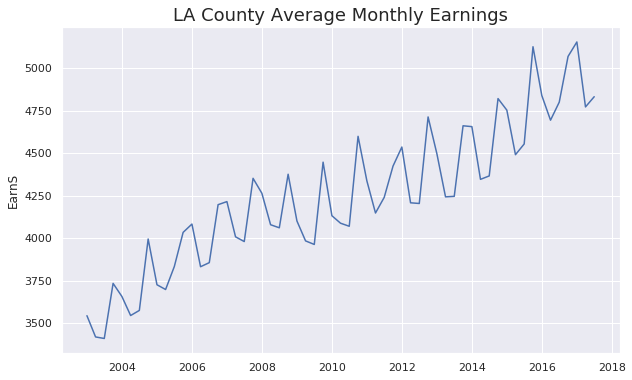

In [21]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_LA_county.index, y = qwi_LA_county['EarnS'])
plt.title(label = 'LA County Average Monthly Earnings', fontsize=18)
plt.show();

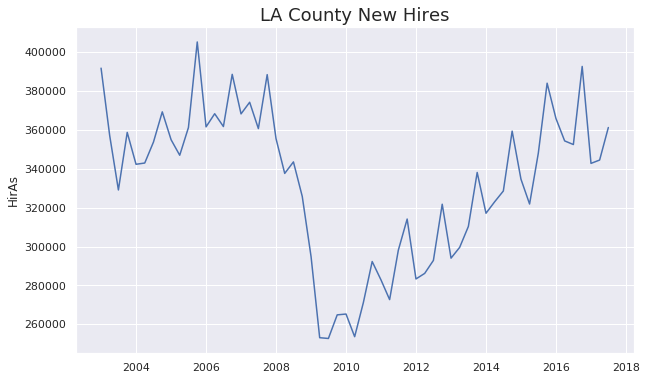

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_LA_county.index, y = qwi_LA_county['HirAs'])
plt.title(label = 'LA County New Hires', fontsize=18)
plt.show();

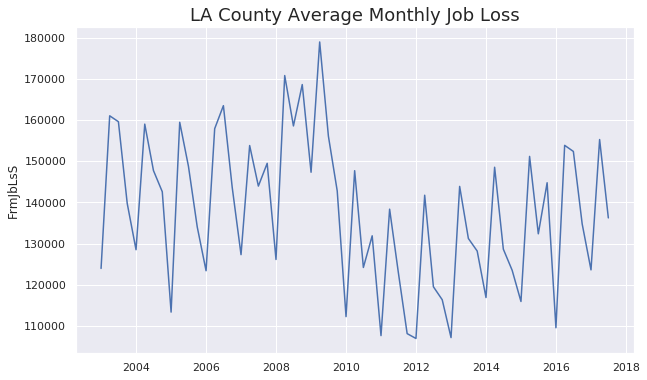

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_LA_county.index, y = qwi_LA_county['FrmJbLsS'])
plt.title(label = 'LA County Average Monthly Job Loss', fontsize=18)
plt.show();

In [24]:
# Isolate LA County
fema_disaster_2003_2018_LA_county = fema_disaster_2003_2018[fema_disaster_2003_2018['county_state'] == 'CA-Los Angeles (County)']

In [25]:
# Count number of disasters quarterly
fema_disaster_2003_2018_LA_county_quarter_year =  fema_disaster_2003_2018_LA_county.groupby('time')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_LA_county_quarter_year

time
2008Q4    5
2007Q4    5
2004Q3    3
2018Q4    2
2005Q3    2
2003Q4    2
2009Q3    2
2017Q4    2
2007Q2    2
2004Q4    1
2005Q1    1
2007Q3    1
2007Q1    1
2008Q2    1
2010Q1    1
2010Q3    1
2017Q1    1
2003Q1    1
Name: Disaster Number, dtype: int64

In [26]:
# Count quarter with most frequent disasters
fema_disaster_2003_2018_LA_county_quarters = fema_disaster_2003_2018_LA_county.groupby('declare_quarter')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_LA_county_quarters

declare_quarter
Q4    17
Q3     9
Q1     5
Q2     3
Name: Disaster Number, dtype: int64

In [27]:
# Count number of disasters by month
fema_disaster_2003_2018_LA_county_months = fema_disaster_2003_2018_LA_county.groupby('declare_month')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_LA_county_months

declare_month
10    9
11    5
07    5
01    4
12    3
08    3
05    2
09    1
04    1
02    1
Name: Disaster Number, dtype: int64

In [28]:
import scipy.stats as stats

In [29]:
LA_county_QEarnS = qwi_LA_county.groupby('time')['EarnS'].mean()
LA_county_QEarnS = pd.DataFrame(LA_county_QEarnS)
LA_county_QEarnS.dropna(inplace = True)

In [30]:
LA_county_QEarnS['year_quarter'] = LA_county_QEarnS.index.str.split('-').str[1]

LA_county_QEarnS[LA_county_QEarnS['year_quarter'] != 'Q4']['EarnS'].mean()

LA_county_Q4_EarnS = LA_county_QEarnS.loc[LA_county_QEarnS['year_quarter'] == 'Q4', 'EarnS']

In [31]:
LA_county_QEarnS.groupby('year_quarter')['EarnS'].mean()

year_quarter
Q1    4299.533333
Q2    4103.666667
Q3    4132.666667
Q4    4467.714286
Name: EarnS, dtype: float64

In [32]:
stats.ttest_1samp(LA_county_Q4_EarnS, LA_county_QEarnS[LA_county_QEarnS['year_quarter'] != 'Q4']['EarnS'].mean())

Ttest_1sampResult(statistic=2.7030478381462286, pvalue=0.018088531492933903)

In [33]:
stats.ttest_ind(LA_county_Q4_EarnS, LA_county_QEarnS[LA_county_QEarnS['year_quarter'] != 'Q4']['EarnS'])

Ttest_indResult(statistic=2.2972756411079134, pvalue=0.025295894733043375)

In [34]:
qwi_LA_county.columns

Index(['EarnBeg', 'EarnHirAS', 'EarnHirNS', 'EarnS', 'EarnSepS', 'Emp',
       'EmpEnd', 'EmpS', 'EmpSpv', 'EmpTotal', 'FrmJbC', 'FrmJbCS', 'FrmJbGn',
       'FrmJbGnS', 'FrmJbLs', 'FrmJbLsS', 'HirA', 'HirAEnd', 'HirAEndR',
       'HirAEndRepl', 'HirAEndReplr', 'HirAs', 'Payroll', 'county',
       'county_codes', 'county_name', 'state', 'state_abv', 'time'],
      dtype='object')

In [35]:
LA_county_FrmJbLsS = qwi_LA_county.groupby('time')['FrmJbLsS'].mean()
LA_county_FrmJbLsS = pd.DataFrame(LA_county_FrmJbLsS)
LA_county_FrmJbLsS.dropna(inplace = True)

In [36]:
LA_county_FrmJbLsS['year_quarter'] = LA_county_FrmJbLsS.index.str.split('-').str[1]

LA_county_FrmJbLsS[LA_county_FrmJbLsS['year_quarter'] != 'Q4']['FrmJbLsS'].mean()

LA_county_Q4_FrmJbLsS = LA_county_FrmJbLsS.loc[LA_county_FrmJbLsS['year_quarter'] == 'Q4', 'FrmJbLsS']

In [37]:
LA_county_FrmJbLsS.groupby('year_quarter')['FrmJbLsS'].mean()

year_quarter
Q1    119315.933333
Q2    154800.333333
Q3    141733.933333
Q4    136329.928571
Name: FrmJbLsS, dtype: float64

In [38]:
# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(qwi_LA_county['FrmJbLsS'].dropna()))

Test Statistic   -1.700003
p-value           0.431111
dtype: float64

In [39]:
qwi_LA_county['FrmJbLsS_difference'] = qwi_LA_county['FrmJbLsS'].diff(9)

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
interpret_dftest(adfuller(qwi_LA_county['FrmJbLsS_difference'].dropna()))

Test Statistic   -3.124235
p-value           0.024811
dtype: float64

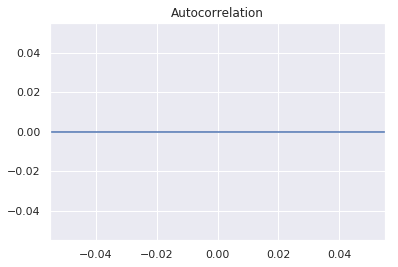

In [41]:
# Plot acf and pacf
plot_acf(qwi_LA_county['FrmJbLsS'], lags = len(fema_disaster_2003_2018_LA_county_quarter_year));

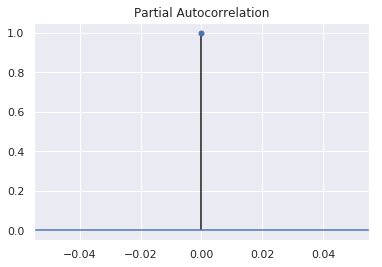

In [42]:
plot_pacf(qwi_LA_county['FrmJbLsS'], lags = len(fema_disaster_2003_2018_LA_county_quarter_year));

In [43]:
qwi_LA_county = qwi_LA_county.dropna()

# Train / test split
qwi_LA_county_train = qwi_LA_county.iloc[:int(qwi_LA_county.shape[0] * .90)]
qwi_LA_county_test = qwi_LA_county.iloc[int(qwi_LA_county.shape[0] * .90):]

In [44]:
# Define start and end of predictions
start = int(qwi_LA_county.shape[0] * .90)
end = qwi_LA_county.shape[0]

In [45]:
targets

['EarnS', 'HirAs', 'FrmJbLsS']

In [46]:
# Forecast optimal p, d, q

mae = 99 * (10 ** 16)
final_p = 0
final_d = 0
final_q = 0

for p in range(5):
    for d in range(2):
        for q in range(5):
            try:
                arima = ARIMA(endog = qwi_LA_county_train[targets[2]], order = (p, d, q))
                model = arima.fit()
                preds = model.predict(start = start, end = end - 1)
                
                # Save for final report.
                if mae > mean_absolute_error(qwi_LA_county_test['FrmJbLsS'], preds):
                    mae = mean_absolute_error(qwi_LA_county_test['FrmJbLsS'], preds)
                    final_p = p
                    final_d = d
                    final_q = q
        
            
            except:
                pass
print(f'Our model that minimizes MAE on the training data is the ARIMA({final_p}, {final_d}, {final_q}).')
print(f'This model has an MAE of {mae}.')

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ashleyw

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different res

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multi

Our model that minimizes MAE on the training data is the ARIMA(4, 0, 2).
This model has an MAE of 11756.92011705733.


/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information w

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


11756.92011705733


/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


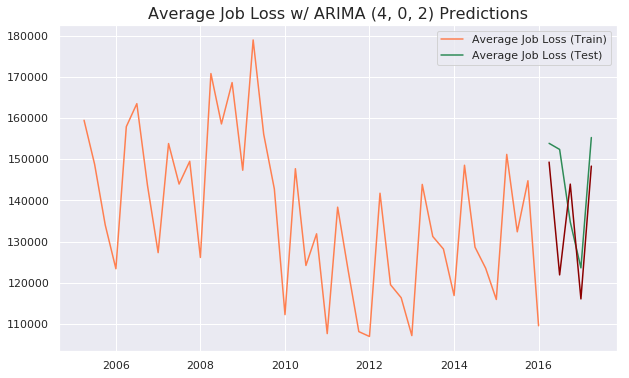

In [47]:
arima = ARIMA(endog = qwi_LA_county_train['FrmJbLsS'],
                 order = (final_p, final_d, final_q))

# Fit SARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start = start, end = end - 1)

# Evaluate predictions.
print(mean_absolute_error(qwi_LA_county_test['FrmJbLsS'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = f'Average Job Loss w/ ARIMA ({final_p}, {final_d}, {final_q}) Predictions', fontsize=16);
sns.lineplot(data=qwi_LA_county_train['FrmJbLsS'], color="coral", label="Average Job Loss (Train)")
sns.lineplot(data=qwi_LA_county_test['FrmJbLsS'], color="seagreen", label="Average Job Loss (Test)")
sns.lineplot(x = qwi_LA_county_test.index, y = preds.values, color = 'darkred')

## Florida

In [30]:
# Filter Florida and check shape
qwi_FL = qwi[qwi['state_abv'] == 'FL']

qwi_FL.dropna(axis = 0, subset= ['EarnS'], inplace = True)

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


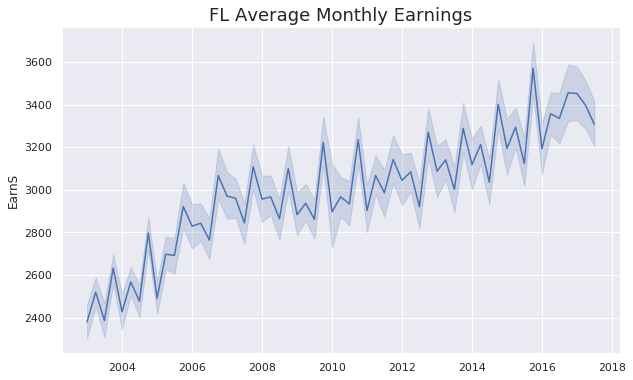

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_FL.index, y = qwi_FL['EarnS'])
plt.title(label = 'FL Average Monthly Earnings', fontsize=18)
plt.show();

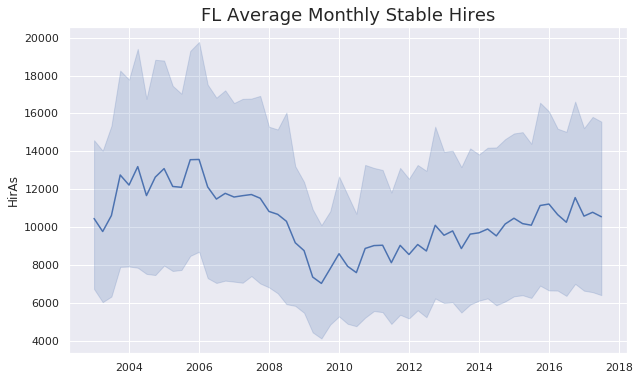

In [32]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_FL.index, y = qwi_FL['HirAs'])
plt.title(label = 'FL Average Monthly Stable Hires', fontsize=18)
plt.show();

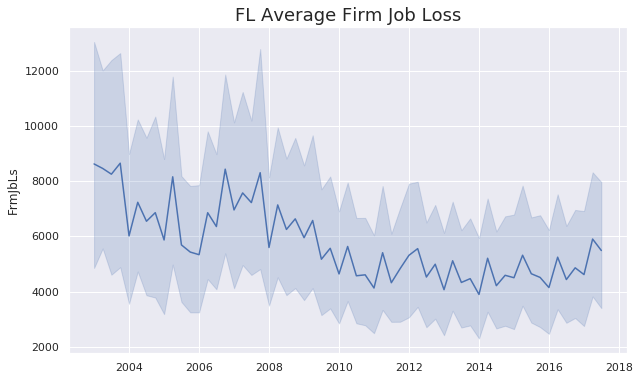

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(x = qwi_FL.index, y = qwi_FL['FrmJbLs'])
plt.title(label = 'FL Average Firm Job Loss', fontsize=18)
plt.show();

In [34]:
# Create dataframe of quarterly average monthly wage
qwi_FL_mean = qwi_FL.groupby(['time', 'county_name'])['EarnS', 'HirAs', 'FrmJbLs'].mean()

qwi_FL_mean = pd.DataFrame(qwi_FL_mean)

In [35]:
# Isolate FL
fema_disaster_2003_2018_FL = fema_disaster_2003_2018[fema_disaster_2003_2018['State '] == 'FL']

In [36]:
# Count number of disasters quarterly
fema_disaster_2003_2018_FL_quarter_year =  fema_disaster_2003_2018_FL.groupby('time')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_FL_quarter_year

time
2004Q3    232
2017Q3    141
2008Q3    118
2005Q3    102
2016Q4     46
2012Q2     34
2016Q3     26
2009Q1     23
2007Q2     22
2005Q4     20
2018Q4     18
2012Q3     12
2003Q2     11
2014Q2      9
2009Q2      6
2007Q1      5
2013Q3      4
2017Q4      2
2008Q2      1
2011Q2      1
2006Q4      1
2006Q2      1
2003Q1      1
Name: Disaster Number, dtype: int64

In [37]:
# Count quarter with most frequent disasters
fema_disaster_2003_2018_FL_quarters = fema_disaster_2003_2018_FL.groupby('declare_quarter')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_FL_quarters

declare_quarter
Q3    635
Q4     87
Q2     85
Q1     29
Name: Disaster Number, dtype: int64

In [38]:
# Count number of disasters by month
fema_disaster_2003_2018_FL_months = fema_disaster_2003_2018_FL.groupby('declare_month')['Disaster Number'].count().sort_values(ascending = False)
fema_disaster_2003_2018_FL_months

declare_month
09    311
08    300
10     86
06     45
05     30
03     25
07     24
04     10
02      4
12      1
Name: Disaster Number, dtype: int64

In [39]:
# Set train / test split
qwi_FL_train = qwi_FL.iloc[:int(qwi_FL.shape[0] * .70)]
qwi_FL_test = qwi_FL.iloc[int(qwi_FL.shape[0] * .70):]

In [40]:
# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(qwi_FL_train['EarnS']))

Test Statistic   -4.664688
p-value           0.000098
dtype: float64

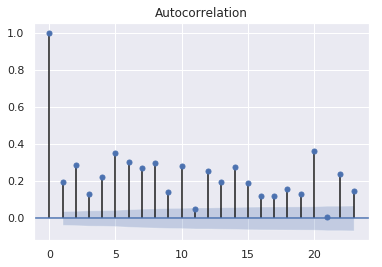

In [41]:
# Plot acf and pacf
plot_acf(qwi_FL_train['EarnS'], lags = len(fema_disaster_2003_2018_FL_quarter_year));

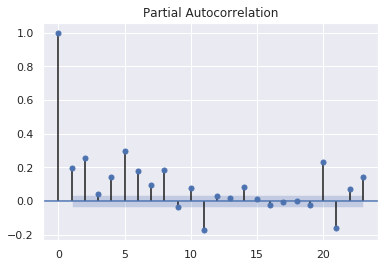

In [42]:
plot_pacf(qwi_FL_train['EarnS'], lags = len(fema_disaster_2003_2018_FL_quarter_year));

In [43]:
# Define start and end of predictions
start = int(qwi_FL.shape[0] * .70)
end = qwi_FL.shape[0]

In [43]:
# Define start and end of predictions
start = int(qwi_FL.shape[0] * .70)
end = qwi_FL.shape[0]

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


414.3551311353378


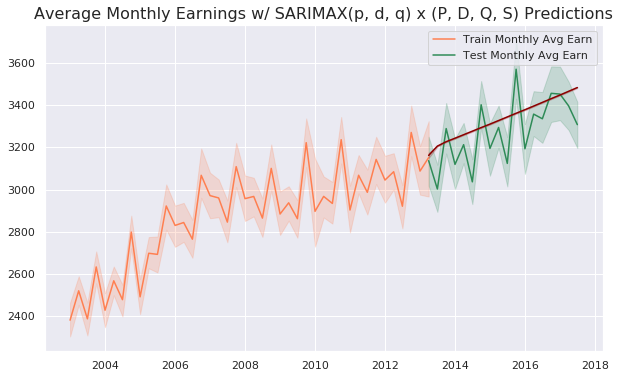

In [44]:
sarima = SARIMAX(endog = qwi_FL_train['EarnS'],
                 order = (4, 0, 4),              # (p, d, q)
                 seasonal_order = (4, 0, 4, 4),
                 enforce_stationarity = False,
                 enforce_invertibility = False)  # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start = start, end = end - 1)

# Evaluate predictions.
print(mean_absolute_error(qwi_FL_test['EarnS'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = 'Average Monthly Earnings w/ SARIMAX(p, d, q) x (P, D, Q, S) Predictions', fontsize=16);
sns.lineplot(data=qwi_FL_train['EarnS'], color="coral", label="Train Monthly Avg Earn")
sns.lineplot(data=qwi_FL_test['EarnS'], color="seagreen", label="Test Monthly Avg Earn")
sns.lineplot(x = qwi_FL_test.index, y = preds.values, color = 'darkred')

In [45]:
qwi.to_csv('../project-4/data/master_qwi_2003_2018_clean.csv')

In [47]:
fema_disaster_2003_2018.to_csv('../project-4/data/fema_disaster_2003_2018_clean.csv')